# Final Proect

### clean up comments dataset

In [26]:
import operator
import string, re, pickle
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
color = sns.color_palette()


from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler

### load dataset

In [286]:
# download annotated comments and annotations
import requests

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

ANNOTATED_COMMENTS = requests.get(ANNOTATED_COMMENTS_URL, allow_redirects=True)
ANNOTATIONS = requests.get(ANNOTATIONS_URL, allow_redirects=True)

open('dataset/attack_annotated_comments.tsv', 'wb').write(ANNOTATED_COMMENTS.content)
open('dataset/attack_annotations.tsv', 'wb').write(ANNOTATIONS.content)

In [27]:
comments = pd.read_csv('dataset/attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('dataset/attack_annotations.tsv',  sep = '\t')

In [28]:
len(annotations['rev_id'].unique())

115864

In [29]:
# labels a comment as an atack if the majority of annoatators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.6

In [30]:
labels.sample(3)

rev_id
594271742    False
437509203    False
28516703     False
Name: attack, dtype: bool

In [31]:
# join labels and comments
comments['attack'] = labels

### Preprocessing 

In [32]:
# util

def remove_punctuation(text):
    punctuations = '''!()-[]{};:'"\,<>.`=/?@#$%^&*_~'''
    no_punct = ""
    for char in text:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct


def word_list(doc):
    wordlist = []
    for r in doc:
        for x in r.split():
            wordlist.append(x)
    return wordlist

def word_fre(wordlist):
    word_freq = {}
    for word in wordlist:
        if word not in word_freq:
            word_freq[word] = 0
        word_freq[word] += 1
    return word_freq

def find_top_high_freq_words():
    wordlist = word_list(comments.comment.tolist())
    wordfreq = word_fre(wordlist)
    sort_freq = sorted(wordfreq.items(), key=operator.itemgetter(1))
    return sort_freq

In [10]:
sort_freq = find_top_high_freq_words()
stop = [x[0] for x in sort_freq]

In [11]:
stop_words = set(stop[:15])

In [33]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

# Removing multiple whitespaces
comments['comment'] = comments['comment'].apply(lambda x: re.sub(r"\?", " \? ", x))

# Remove numbers
comments['comment'] = comments['comment'].apply(lambda x: re.sub(r"[0-9]+", "", x))
# lower case
comments['comment'] = comments['comment'].apply(lambda x: x.lower())
# remove all punctuation
comments['comment'] = comments['comment'].apply(lambda x: x.replace(string.punctuation, " "))
comments['comment'] = comments['comment'].apply(lambda x: remove_punctuation(x))


# Removing multiple whitespaces
comments['comment'] = comments['comment'].apply(lambda x: re.sub(r"\?", " \? ", x))

# remove URL
comments['comment'] = comments['comment'].apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', "", x, flags=re.MULTILINE))


# remove english stop words
# new_comment = []
# for index, row in comments.iterrows():
#     words = [w for w in row['comment'].split() if not w in stop_words]
#     new_comment.append(' '.join(words))
# comments['comment'] = new_comment

comments = comments.replace(np.nan, '', regex=True)
# Removing multiple whitespaces
comments['comment'] = comments['comment'].apply(lambda x: re.sub(r"\?", " \? ", x))

In [57]:
# with open('dataset/clearn_up_comments.pickle', 'wb') as f:
#     pickle.dump(comments, f)

In [58]:
# with open('dataset/clearn_up_comments.pickle', 'rb') as f:
#     comments = pickle.load(f)

In [34]:
comments.count()

comment      115864
year         115864
logged_in    115864
ns           115864
sample       115864
split        115864
attack       115864
dtype: int64

In [35]:
comments.sample(5)

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
224891827,no its a secret project with no confirmation...,2008,False,article,blocked,test,False
662882399,rfa please dont badger opposers of an rfa...,2015,True,user,blocked,test,False
230723384,unblock| oxymoron is a moron in an oxymoron ...,2008,False,user,blocked,train,True
330174799,birthday note a little late on my part bu...,2009,True,user,random,test,False
138838973,and you should note that i am not wrong tha...,2007,True,user,blocked,dev,False


In [51]:
# query with boolean expression
comments.query('attack')['logged_in'].count()

11107

In [52]:
logout = comments[comments.logged_in == False]
print(logout.count())
out_a = comments[comments.attack == True]
print(out_a.count())

comment      30946
year         30946
logged_in    30946
ns           30946
sample       30946
split        30946
attack       30946
dtype: int64
comment      11107
year         11107
logged_in    11107
ns           11107
sample       11107
split        11107
attack       11107
dtype: int64


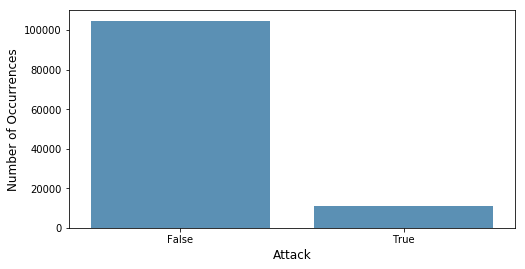

In [136]:
attack_level = comments['attack'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(attack_level.index, attack_level.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Attack', fontsize=12)
plt.show()

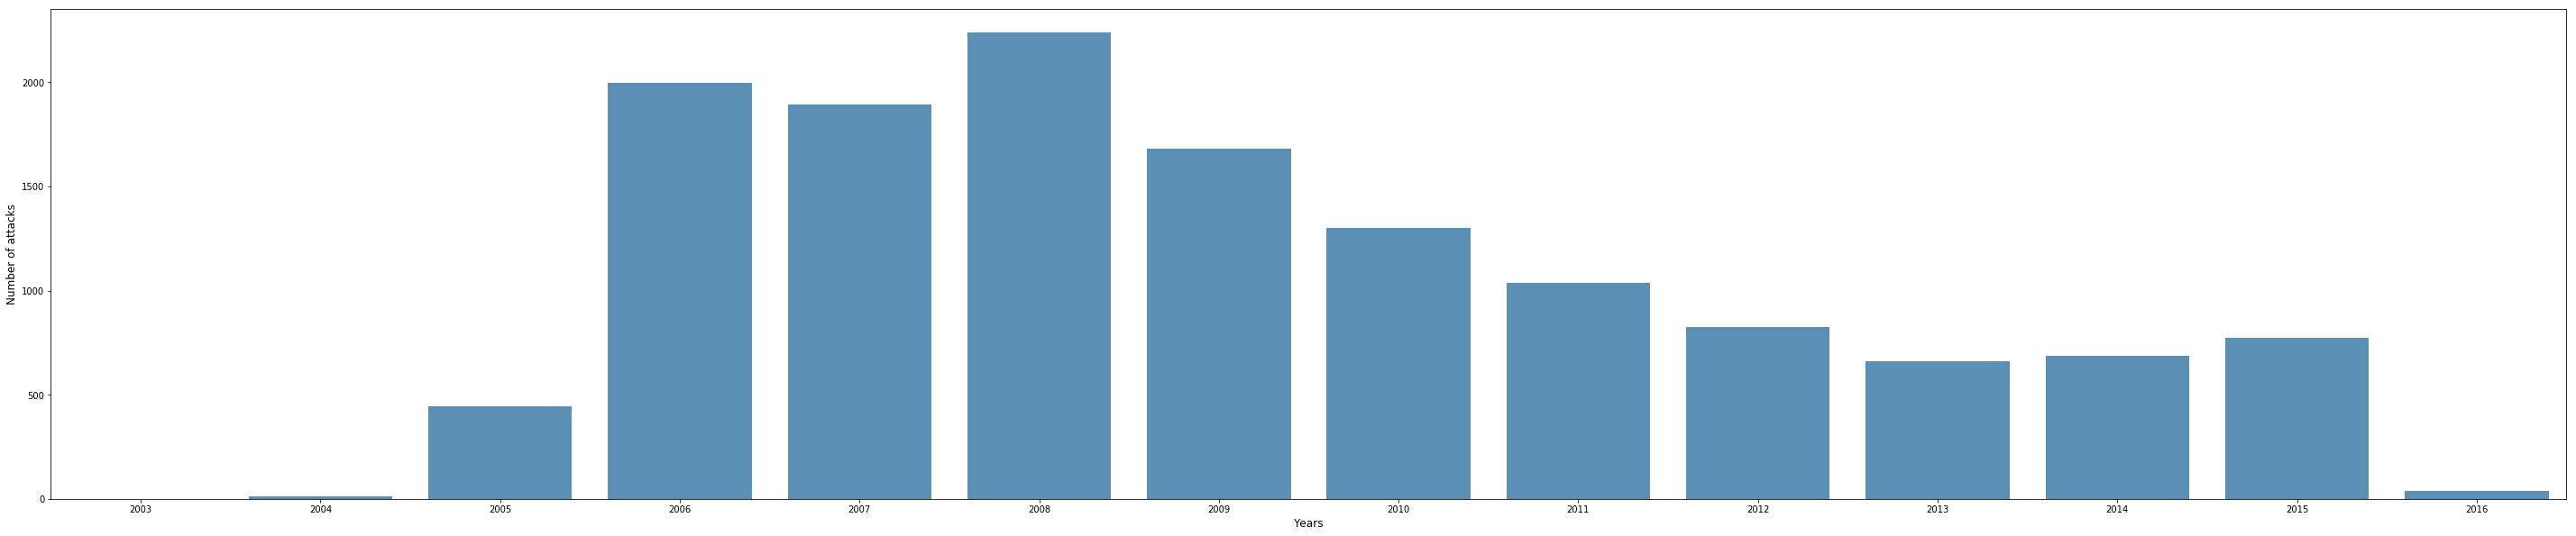

In [25]:
years = comments.query('attack').groupby('year').count()
years = years.attack
plt.figure(figsize=(50,10))
sns.barplot(years.index, years.values, alpha=0.8, color=color[0])
plt.ylabel('Number of attacks', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

In [36]:
train_comments = comments.query("split=='train'")
dev_comments = comments.query("split=='dev'")
test_comments = comments.query("split=='test'")

In [37]:
# get rid of rev_id, year, logged_in, ns, sample column that will not be used in training
# only keep comments as training feature
def get_X_Y(data):
    X = data.comment
    Y = data.iloc[:, -1]
    return X, Y

In [38]:
X_train, Y_train = get_X_Y(train_comments)
X_dev, Y_dev = get_X_Y(dev_comments)
X_test, Y_test = get_X_Y(test_comments)

In [39]:
X_train.sample(10)

rev_id
241552424      joseph stalin please stop adding unsourced n...
385983088                         a user you banned i assume  
61108043     there should be a note about criticism of the ...
321655093                           sorry i dont speek spanish
295520884     im sorry but that would be utterly retarded  ...
627057148     im only looking for some help thats it nothin...
437012137      update on opposition parties  httpwwwbbccouk...
96481950      even look at marty sertichs wiki page  high s...
253175145     further to this it would be appeciated if you...
182692555      another movie sleep easy hutch rimes was als...
Name: comment, dtype: object

## LogisticRegression

In [40]:
# fit a simple text classifier
lr_clf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression()),
])
lr_clf = lr_clf.fit(X_train, Y_train)
auc = roc_auc_score(Y_test, lr_clf.predict_proba(X_test)[:, 1])
print('Test ROC AUC: %.3f' %auc)
predicted = lr_clf.predict(X_test)
print(metrics.classification_report(Y_test, predicted))

Test ROC AUC: 0.966
             precision    recall  f1-score   support

      False       0.95      0.99      0.97     20913
       True       0.92      0.55      0.69      2265

avg / total       0.95      0.95      0.95     23178



In [19]:
# hyper-parameter tuning
text_clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000)),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression(n_jobs=-1)),
])

In [20]:
param_grid = { 
           "clf__penalty" : ['l1', 'l2'],
           "clf__C" : [1.0, 5.0],
           "clf__max_iter" : [100, 150]}

from pprint import pprint
pprint(param_grid)

{'clf__C': [1.0, 5.0],
 'clf__max_iter': [100, 150],
 'clf__penalty': ['l1', 'l2']}


In [174]:
from sklearn.model_selection import GridSearchCV

gs_clf = GridSearchCV(estimator=text_clf, param_grid=param_grid, n_jobs=-1)
gs_clf.fit(train_comments['comment'], train_comments['attack'])

/Users/xiaofan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/Users/xiaofan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/Users/xiaofan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/Users/xiaofan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/Users/xiaofan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/lo

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 5.0], 'clf__max_iter': [100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [175]:
print(gs_clf.best_score_)
for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

0.954693208296
clf__C: 1.0
clf__max_iter: 100
clf__penalty: 'l1'


## MultinomialNB

In [41]:
mnb = Pipeline([
    ('vect', CountVectorizer(analyzer='word', max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', MultinomialNB()),
])
mnb = mnb.fit(X_train, Y_train)
auc = roc_auc_score(Y_test, mnb.predict_proba(X_test)[:, 1])
print('Test ROC AUC: %.3f' %auc)
predicted = mnb.predict(X_test)
print(metrics.classification_report(Y_test, predicted))

Test ROC AUC: 0.946
             precision    recall  f1-score   support

      False       0.95      0.99      0.97     20913
       True       0.87      0.52      0.65      2265

avg / total       0.94      0.95      0.94     23178



##  RandomForestClassifier

In [42]:
rfc = Pipeline([
    ('vect', CountVectorizer(analyzer='word', max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', RandomForestClassifier(n_estimators=20,
#                                    max_features='sqrt', 
#                                    min_samples_leaf=15, 
#                                    min_samples_split=5, 
#                                    max_depth= 50, 
#                                    class_weight='balanced_subsample',
                                   random_state=0)
                                   ),
])
rfc = rfc.fit(X_train, Y_train)
auc = roc_auc_score(Y_test, rfc.predict_proba(X_test)[:, 1])
print('Test ROC AUC: %.3f' %auc)
predicted = rfc.predict(X_test)
print(metrics.classification_report(Y_test, predicted))

Test ROC AUC: 0.934
             precision    recall  f1-score   support

      False       0.95      0.99      0.97     20913
       True       0.90      0.53      0.66      2265

avg / total       0.95      0.95      0.94     23178



In [158]:
# hyper-parameter tuning
text_clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000)),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', RandomForestClassifier(n_jobs=-1)),
])

In [159]:
param_grid = { 
           "clf__n_estimators" : [300, 500, 700],
           "clf__max_depth" : [100, 200, 300],
           "clf__min_samples_leaf" : [20, 50, 80]}

from pprint import pprint
pprint(param_grid)

{'clf__max_depth': [100, 200, 300],
 'clf__min_samples_leaf': [20, 50, 80],
 'clf__n_estimators': [300, 500, 700]}


In [161]:
from sklearn.model_selection import GridSearchCV

gs_clf = GridSearchCV(estimator=text_clf, param_grid=param_grid, n_jobs=-1)
# gs_clf.fit(train_comments['comment'], train_comments['attack'])

##  SVC

In [43]:
linear_svc = Pipeline([
    ('vect', CountVectorizer(analyzer='word', max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LinearSVC()),
])
linear_svc = linear_svc.fit(X_train, Y_train)
auc = linear_svc.score(X_test, Y_test)
print('Test ROC AUC: %.3f' %auc)
predicted = linear_svc.predict(X_test)
print(metrics.classification_report(Y_test, predicted))

Test ROC AUC: 0.955
             precision    recall  f1-score   support

      False       0.96      0.99      0.98     20913
       True       0.87      0.64      0.74      2265

avg / total       0.95      0.96      0.95     23178



## MLPClassifier

In [44]:
mlp = Pipeline([
    ('vect', CountVectorizer(analyzer='word', max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', MLPClassifier()),
])
mlp = mlp.fit(X_train, Y_train)
auc = roc_auc_score(Y_test, mlp.predict_proba(X_test)[:, 1])
print('Test ROC AUC: %.3f' %auc)
predicted = mlp.predict(X_test)
print(metrics.classification_report(Y_test, predicted))

Test ROC AUC: 0.925
             precision    recall  f1-score   support

      False       0.96      0.97      0.97     20913
       True       0.71      0.64      0.68      2265

avg / total       0.94      0.94      0.94     23178



# Analysis

In [ ]:
# correctly classify nice comment
lr_clf.predict(['Thanks for you contribution, you did a great job!'])

In [270]:
# correctly classify nasty comment
lr_clf.predict(['People as stupid as you should not edit Wikipedia!'])

array([ True], dtype=bool)

In [271]:
from sklearn.metrics import confusion_matrix
y_val_pred = lr_clf.predict_proba(test_comments['comment'])
y_val = test_comments.attack
log_loss(y_val, y_val_pred)

0.15717916480915986

In [272]:
preds = lr_clf.predict(test_comments['comment'])

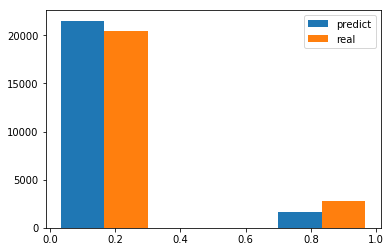

In [273]:
bins = np.linspace(0, 1, 4)
data = np.vstack([preds, y_val]).T
plt.hist(data, bins, alpha=1, label=['predict','real'])
plt.legend(loc='upper right')
plt.show()

In [274]:
from sklearn.metrics import classification_report

target_names = ['not_attack', 'attack']
print(classification_report(preds, y_val, target_names=target_names))

             precision    recall  f1-score   support

 not_attack       0.99      0.94      0.97     21516
     attack       0.55      0.91      0.69      1662

avg / total       0.96      0.94      0.95     23178



In [275]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, preds)

array([[20280,   142],
       [ 1236,  1520]])

In [181]:
average_precision['micro']

0.55772859664985908

## CNN

In [15]:
import keras, os, pickle, re, sklearn, string, tensorflow
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.layers import Embedding
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Parameter

In [16]:
# EMBEDDING
MAX_NUM_WORDS  = 15000
EMBEDDING_DIM  = 300
MAX_SEQ_LENGTH = 200
USE_GLOVE      = True
USE_W2V        = True

# MODEL
FILTER_SIZES   = [3,4,5]
FEATURE_MAPS   = [10,10,10]
DROPOUT_RATE   = 0.5

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 40
RUNS           = 5
VAL_SIZE       = 0.1

###  Tokenizer

In [167]:
docs = X_train.tolist()
test_docs = X_test.tolist()

In [60]:
def max_length(lines):
    """
    Calculate the maximum document length
    """
    return max([len(s.split()) for s in lines])

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(docs)
sequences = tokenizer.texts_to_sequences(docs)

length = max_length(docs)
word_index = tokenizer.word_index
result = [len(x.split()) for x in docs]

print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))
print('vacobulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

Text informations:
max length: 2500 / min length: 0 / mean length: 40 / limit length: 200
vacobulary size: 118977 / limit: 15000


In [61]:
test_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
test_tokenizer.fit_on_texts(test_docs)
test_sequences = test_tokenizer.texts_to_sequences(test_docs)

test_length = max_length(test_docs)
test_word_index = tokenizer.word_index
test_result = [len(x.split()) for x in test_docs]

print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(test_result),
                                                                                np.min(test_result),
                                                                                np.mean(test_result),
                                                                                MAX_SEQ_LENGTH))
print('vacobulary size: %i / limit: %i' % (len(test_word_index), MAX_NUM_WORDS))

Text informations:
max length: 2500 / min length: 0 / mean length: 40 / limit length: 200
vacobulary size: 118977 / limit: 15000


In [62]:
# Padding all sequences to same length of `MAX_SEQ_LENGTH`
x_train = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
y_train = Y_train.tolist()
x_val = pad_sequences(test_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
y_val = Y_test.tolist()

### Embeddings

In [63]:
def create_glove_embeddings():
    print('Pretrained embeddings GloVe is loading...')

    embeddings_index = {}
    f = open('glove.6B.300d.sample.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors in GloVe embedding' % len(embeddings_index))

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,
                     input_length=MAX_SEQ_LENGTH,
                     weights=[embedding_matrix],
                     trainable=True
                    )

In [ ]:
from gensim.models import word2vec

In [ ]:
def create_w2v_embeddings():
    print('Pretrained embeddings w2v is loading...')
    
    model = word2vec.Word2Vec.load('w2v_model')
    embeddings_index = {}

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        if word in model.wv:
            embedding_vector = model.wv[word]
            embedding_matrix[i] = embedding_vector
        #if embedding_vector is not None:
            

    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,
                     input_length=MAX_SEQ_LENGTH,
                     weights=[embedding_matrix],
                     trainable=True
                    )

In [37]:
data

array([[2093, 2727,  670, ...,  524, 1148,  697],
       [ 280,  762, 1982, ...,    0,    0,    0],
       [ 266,  418,  843, ...,    0,    0,    0],
       ..., 
       [  40,    9,  517, ...,    0,    0,    0],
       [  46,   36,   76, ...,    0,    0,    0],
       [4174, 2330,  292, ...,    0,    0,    0]], dtype=int32)

In [24]:
label = Y_train.tolist()

In [35]:
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

69526
23178
69526
23178


### Training

In [65]:
import cnn_model

histories = []

for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    
#     x_train, x_val, y_train, y_val = train_test_split(data, label, test_size=VAL_SIZE, random_state=42)
    
    
    if USE_W2V:
        emb_layer = create_w2v_embeddings()
    elif USE_GLOVE:
        emb_layer = create_glove_embeddings()
    else:
    emb_layer = None
    
    model = cnn_model.build_cnn(
        embedding_layer=emb_layer,
        num_words=MAX_NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        filter_sizes=FILTER_SIZES,
        feature_maps=FEATURE_MAPS,
        max_seq_length=MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE
    )
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adadelta(clipvalue=3),
        metrics=['accuracy']
    )
    
    history = model.fit(
        x_train, y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=(x_val, y_val),
        callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                   verbose=1, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    print()
    histories.append(history.history)

Running iteration 1/5
Pretrained embeddings GloVe is loading...
Found 100 word vectors in GloVe embedding
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 15000
Embedding dim: 300
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 200
#############################################
Train on 69526 samples, validate on 23178 samples
Epoch 1/40
  800/69526 [..............................] - ETA: 21:40 - loss: 2.2548 - acc: 0.7700

KeyboardInterrupt: 

In [64]:
print(len(x_train))
print(len(x_val))

69526
23178
